# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import os
import skimage.io as io
import skimage.transform as trans
import shutil
import cv2
import matplotlib.pyplot as plt
import pickle
import time
from __future__ import print_function
import glob
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tensorflow.keras.models import load_model as load_initial_model
from google.colab.patches import cv2_imshow
import gc

# Handcrafted Metrics For Additional Evaluation

In [ ]:
def dice_coef(y_true, y_pred):
  smooth = 0.0
  y_true_f = keras.flatten(y_true)
  y_pred_f = keras.flatten(y_pred)
  intersection = keras.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

  y_true_f = keras.flatten(y_true)
  y_pred_f = keras.flatten(y_pred)
  intersection = keras.sum ( y_true_f * y_pred_f)
  union = keras.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

  return intersection/union

# The Model

In [ ]:
def unet(pretrained_weights = None,input_size = (80,80,1)):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(inputs,conv10)

  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy',dice_coef,jacard, tf.keras.metrics.AUC(), tf.keras.metrics.MeanIoU(num_classes=2),
                                                                                      tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  #model.summary()

  # if(pretrained_weights):
  #   model.load_weights(pretrained_weights)

  return model

# Generators

In [ ]:
def adjustData(img,mask,flag_multi_class,num_class):
  if(flag_multi_class):
    img = img / 255
    mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
    new_mask = np.zeros(mask.shape + (num_class,))
    for i in range(num_class):
        #for one pixel in the image, find the class in mask and convert it into one-hot vector
        #index = np.where(mask == i)
        #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
        #new_mask[index_mask] = 1
        new_mask[mask == i,i] = 1
    new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
    mask = new_mask
  elif (np.max(img) > 1):
    img = img / 255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
  return (img,mask)

In [ ]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (80,80),seed = 1):
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  image_generator = image_datagen.flow_from_directory(
      train_path,
      classes = [image_folder],
      class_mode = None,
      color_mode = image_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = image_save_prefix,
      seed = seed)
  mask_generator = mask_datagen.flow_from_directory(
      train_path,
      classes = [mask_folder],
      class_mode = None,
      color_mode = mask_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = mask_save_prefix,
      seed = seed)
  train_generator = zip(image_generator, mask_generator)
  for (img,mask) in train_generator:
    img,mask = adjustData(img,mask,flag_multi_class,num_class)
    yield (img,mask)

In [ ]:
def testGenerator(test_path, target_size = (80,80),flag_multi_class = False,as_gray = True):
  image_datagen = ImageDataGenerator(rescale=1./255)
  mask_datagen = ImageDataGenerator(rescale=1./255)

  for img_name in sorted(os.listdir(test_path + "/images")):
      img = io.imread(os.path.join(test_path + "/images",img_name),as_gray = as_gray)
      img = img / 255
      img = trans.resize(img,target_size)
      img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
      img = np.reshape(img,(1,)+img.shape)
      yield img

In [ ]:
def testGenerator2(batch_size,test_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (512,512),seed = 1):
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  image_generator = image_datagen.flow_from_directory(
      test_path,
      classes = [image_folder],
      class_mode = None,
      color_mode = image_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = image_save_prefix,
      seed = seed)
  mask_generator = mask_datagen.flow_from_directory(
      test_path,
      classes = [mask_folder],
      class_mode = None,
      color_mode = mask_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = mask_save_prefix,
      seed = seed)
  test_generator = zip(image_generator, mask_generator)
  for (img,mask) in test_generator:
    img,mask = adjustData(img,mask,flag_multi_class,num_class)
    yield (img,mask)

# Utils

In [ ]:
def pad(input_folder, output_folder):
  for file in sorted(os.listdir(input_folder)):
    if '.png' in file:
      tmp = cv2.imread(input_folder + '/' + file, 0)
      tmp = cv2.copyMakeBorder(tmp.copy(),12,12,5,6,cv2.BORDER_CONSTANT,value=(0,0,0))
      io.imsave(output_folder + '/' + file, tmp)
  print('Padding is done.')

In [ ]:
def crop(input_folder, output_folder):
  for file in sorted(os.listdir(input_folder)):
    if '.png' in file:
      tmp = cv2.imread(input_folder + '/' + file, 0)
      tmp = tmp[12:-12, 5:-6]
      io.imsave(output_folder + '/' + file, tmp)
  print('Cropping is done.')

In [ ]:
def saveResult_drive(save_path,npyfile,flag_multi_class = False,num_class = 2):
  for i,item in enumerate(npyfile):
      img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
      io.imsave(os.path.join(save_path,"%d.png"%(i)),img)

In [ ]:
def threshold(folder):
  for img in sorted(os.listdir(folder)):
    tmp = cv2.imread(folder + '/' + img, 0)
    _, tmp = cv2.threshold(tmp,115,255,cv2.THRESH_BINARY)
    io.imsave(folder + '/' + img, tmp)

In [ ]:
def set_order(input_folder, output_folder):

  for img in sorted(os.listdir(input_folder)):

    if int(img.split('.')[0]) == 0:
      tmp = cv2.imread(input_folder  + '/' + img, 0)
      io.imsave(output_folder + '/' + str(int(img.split('.')[0])+1) + '.png', tmp)
    elif int(img.split('.')[0]) >= 1 and int(img.split('.')[0]) <= 10:
      tmp = cv2.imread(input_folder  + '/' + img, 0)
      io.imsave(output_folder + '/' + str(int(img.split('.')[0])+9) + '.png', tmp)
    elif int(img.split('.')[0]) >= 13 and int(img.split('.')[0]) <= 19:
      tmp = cv2.imread(input_folder  + '/' + img, 0)
      io.imsave(output_folder + '/' + str(int(img.split('.')[0])-10) + '.png', tmp)
    elif int(img.split('.')[0]) == 11:
      tmp = cv2.imread(input_folder  + '/' + img, 0)
      io.imsave(output_folder + '/' + str(int(img.split('.')[0])-9) + '.png', tmp)
    elif int(img.split('.')[0]) == 12:
      tmp = cv2.imread(input_folder  + '/' + img, 0)
      io.imsave(output_folder + '/' + str(int(img.split('.')[0])+8) + '.png', tmp)

In [ ]:
def dice(true_mask, pred_mask, non_seg_score=1.0):
    """
        Computes the Dice coefficient.
        Args:
            true_mask : Array of arbitrary shape.
            pred_mask : Array with the same shape than true_mask.

        Returns:
            A scalar representing the Dice coefficient between the two segmentations.

    """
    assert true_mask.shape == pred_mask.shape

    true_mask = np.asarray(true_mask).astype(np.bool)
    pred_mask = np.asarray(pred_mask).astype(np.bool)

    # If both segmentations are all zero, the dice will be 1. (Developer decision)
    im_sum = true_mask.sum() + pred_mask.sum()
    if im_sum == 0:
        return non_seg_score

    # Compute Dice coefficient
    intersection = np.logical_and(true_mask, pred_mask)
    return 2. * intersection.sum() / im_sum

In [ ]:
def mean_dice(true_path, pred_path):

  sum = 0

  for img in sorted(os.listdir(pred_path)):

    true_tmp = cv2.imread(true_path + '/' + img, 0)
    pred_tmp = cv2.imread(pred_path + '/' + img, 0)

    a = dice(true_tmp, pred_tmp)
    print(a)
    sum += a

  return sum/len(os.listdir(true_path))

# DRIVE

In [ ]:
LOG_PATH      = '/content/drive/MyDrive/project/calcium_data/U-net/logs'
RESULT_PATH   = '/content/drive/MyDrive/project/calcium_data/U-net/test_results'
MODEL_PATH    = '/content/drive/MyDrive/project/calcium_data/U-net/models'

TRAIN_PATH    = '/content/drive/MyDrive/project/calcium_data/combinations_png'
VAL_PATH      = '/content/drive/MyDrive/project/calcium_data/test'
TEST_PATH     = '/content/drive/MyDrive/project/calcium_data/test'

TMP_TRAIN     = '/content/drive/MyDrive/project/calcium_data/U-net/tmp_train'
TMP_TEST      = '/content/drive/MyDrive/project/calcium_data/U-net/tmp_test'
TMP_VAL       = '/content/drive/MyDrive/project/calcium_data/U-net/tmp_val'
TMP_RESULT    = '/content/drive/MyDrive/project/calcium_data/U-net/tmp_result'

if (os.path.isdir(LOG_PATH) and os.path.isdir(RESULT_PATH) and \
    os.path.isdir(MODEL_PATH) and os.path.isdir(TRAIN_PATH)) and \
    os.path.isdir(TEST_PATH) and os.path.isdir(VAL_PATH) and \
    os.path.isdir(TMP_TRAIN) and os.path.isdir(TMP_TEST) and \
    os.path.isdir(TMP_VAL) and os.path.isdir(TMP_RESULT) == 0:
    raise OSError()


## Train Many Epochs at Once

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
train_batch = 3
test_batch = 3
epoch = 2

In [ ]:
num_train = len(os.listdir(TRAIN_PATH + '/images'))
num_test  = len(os.listdir(TEST_PATH + '/images'))

In [ ]:
shutil.rmtree(TMP_TRAIN, ignore_errors=False, onerror=None)
os.mkdir(TMP_TRAIN)
os.mkdir(TMP_TRAIN + "/images")
os.mkdir(TMP_TRAIN + "/labels")

shutil.rmtree(TMP_TEST, ignore_errors=False, onerror=None)
os.mkdir(TMP_TEST)
os.mkdir(TMP_TEST + "/images")
os.mkdir(TMP_TEST + "/labels")


shutil.rmtree(TMP_VAL, ignore_errors=False, onerror=None)
os.mkdir(TMP_VAL)
os.mkdir(TMP_VAL + "/images")
os.mkdir(TMP_VAL + "/labels")

pad(TRAIN_PATH + '/images', TMP_TRAIN + '/images')
pad(TRAIN_PATH + '/labels', TMP_TRAIN + '/labels')

pad(TEST_PATH + '/images', TMP_TEST + '/images')
pad(TEST_PATH + '/labels', TMP_TEST + '/labels')

pad(VAL_PATH + '/images', TMP_VAL + '/images')
pad(VAL_PATH + '/labels', TMP_VAL + '/labels')

data_gen_args = dict()
train_generator = trainGenerator(train_batch, TMP_TRAIN, 'images', 'labels', data_gen_args, save_to_dir = None, target_size=(80,80))
test_generator = testGenerator2(test_batch, TMP_TEST, 'images', 'labels', data_gen_args, save_to_dir = None, target_size=(80,80))

# model = unet(input_size=(512,512,1))
  # if initial_model_path != None:
  #   model.load_weights(initial_model_path)

Padding is done.
Padding is done.
Padding is done.
Padding is done.
Padding is done.
Padding is done.


In [ ]:
model = unet(input_size=(80,80,1))

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.summary()

In [ ]:
from keras.models import load_model
# model = load_model("/content/drive/MyDrive/dendrites_cal/U_net/models/my_model11.hdf5", compile=False)
model = load_model('/content/drive/MyDrive/project/calcium_data/U-net/models/hellacells_unet_50epochs.hdf5', compile = True, custom_objects = {'dice_coef':dice_coef, 'jacard': jacard})

In [ ]:
model_checkpoint = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100,
    verbose=0)
  #(monitor='loss',verbose=0, save_best_only=True)

model_history = model.fit(train_generator, steps_per_epoch=num_train//train_batch, epochs=100, callbacks=[model_checkpoint],
                                      validation_data=test_generator, validation_steps=num_test//test_batch)


Found 318 images belonging to 1 classes.
Found 318 images belonging to 1 classes.
Epoch 1/100
106/106 [==============================] - ETA: 0s - loss: 0.3041 - accuracy: 0.9694 - dice_coef: 0.7787 - jacard: 0.6391 - auc: 0.9851 - mean_io_u: 0.2911 - precision: 0.9684 - recall: 0.9617Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
106/106 [==============================] - 131s 957ms/step - loss: 0.3041 - accuracy: 0.9694 - dice_coef: 0.7787 - jacard: 0.6391 - auc: 0.9851 - mean_io_u: 0.2911 - precision: 0.9684 - recall: 0.9617 - val_loss: 0.5028 - val_accuracy: 0.9204 - val_dice_coef: 0.6422 - val_jacard: 0.4729 - val_auc: 0.9380 - val_mean_io_u: 0.3484 - val_precision: 0.8515 - val_recall: 0.8938
Epoch 2/100
106/106 [==============================] - 106s 1s/step - loss: 0.2874 - accuracy: 0.9797 - dice_coef: 0.7889 - jacard: 0.6527 - auc: 0.9903 - mean_io_u: 0.2857 - precision: 0.9788 - recall: 0.9749 - val_loss: 0.5225 - val_accuracy: 0.9198 - val_dic

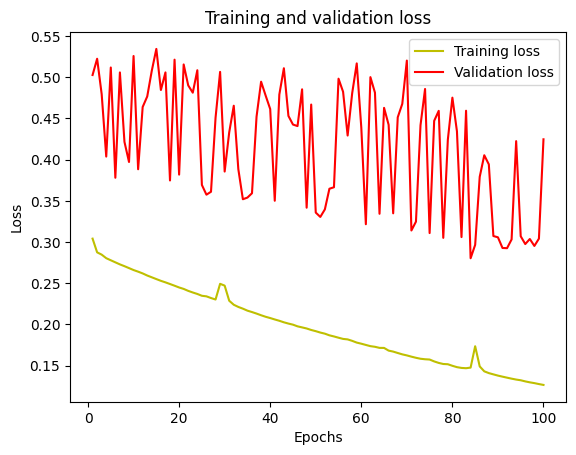

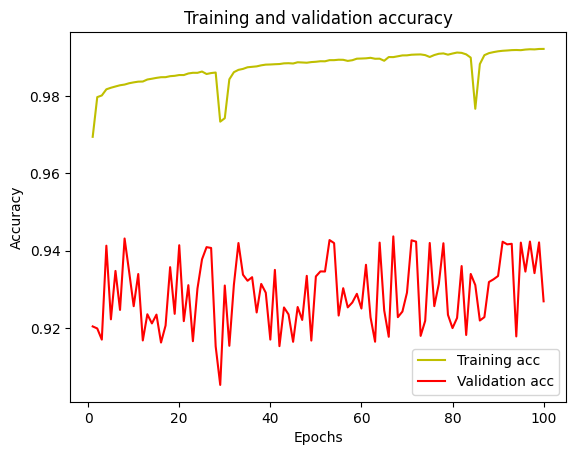

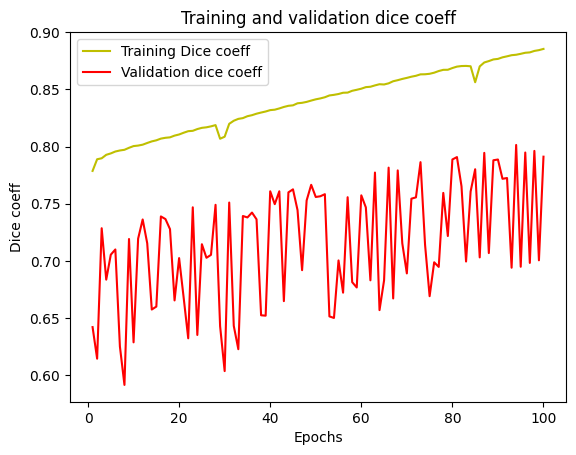

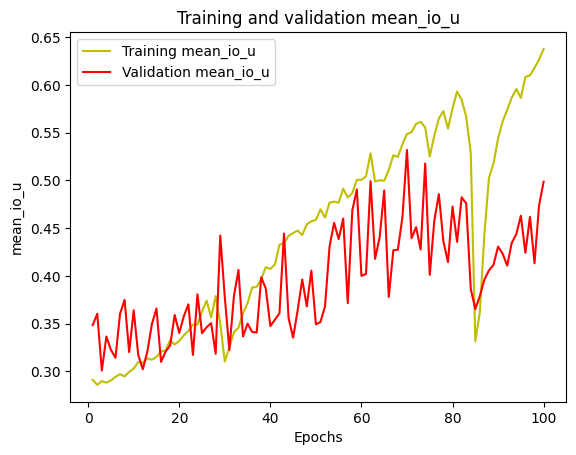

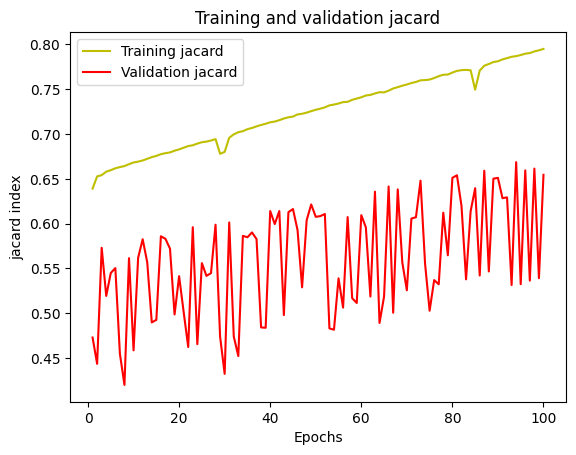

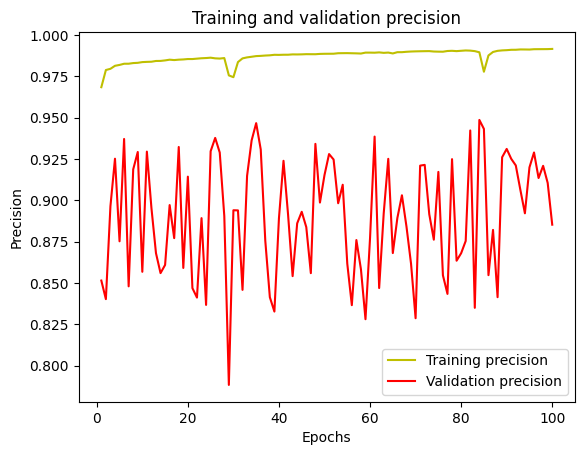

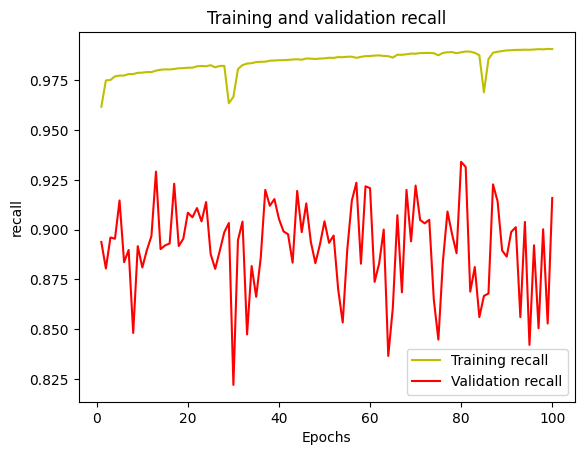

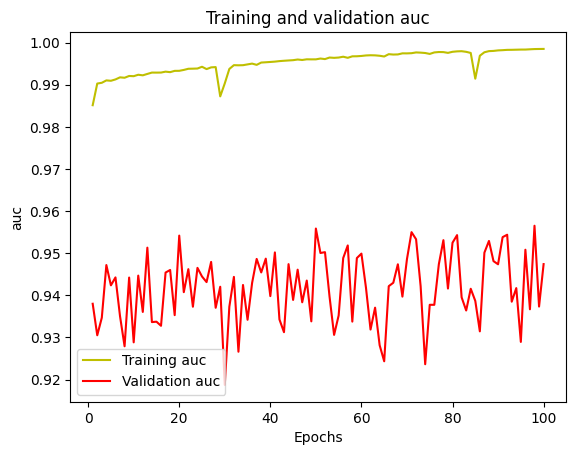

In [ ]:
##Results with 50 epochs
#plot the training and validation accuracy and loss at each epoch
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

acc = model_history.history['dice_coef']
val_acc = model_history.history['val_dice_coef']
plt.plot(epochs, acc, 'y', label='Training Dice coeff')
plt.plot(epochs, val_acc, 'r', label='Validation dice coeff')
plt.title('Training and validation dice coeff')
plt.xlabel('Epochs')
plt.ylabel('Dice coeff')
plt.legend()
plt.show()

acc = model_history.history['mean_io_u']
val_acc = model_history.history['val_mean_io_u']
plt.plot(epochs, acc, 'y', label='Training mean_io_u')
plt.plot(epochs, val_acc, 'r', label='Validation mean_io_u')
plt.title('Training and validation mean_io_u')
plt.xlabel('Epochs')
plt.ylabel('mean_io_u')
plt.legend()
plt.show()

acc = model_history.history['jacard']
val_acc = model_history.history['val_jacard']
plt.plot(epochs, acc, 'y', label='Training jacard')
plt.plot(epochs, val_acc, 'r', label='Validation jacard')
plt.title('Training and validation jacard')
plt.xlabel('Epochs')
plt.ylabel('jacard index')
plt.legend()
plt.show()

acc = model_history.history['precision']
val_acc = model_history.history['val_precision']
plt.plot(epochs, acc, 'y', label='Training precision')
plt.plot(epochs, val_acc, 'r', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

acc = model_history.history['recall']
val_acc = model_history.history['val_recall']
plt.plot(epochs, acc, 'y', label='Training recall')
plt.plot(epochs, val_acc, 'r', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()
plt.show()


acc = model_history.history['auc']
val_acc = model_history.history['val_auc']
plt.plot(epochs, acc, 'y', label='Training auc')
plt.plot(epochs, val_acc, 'r', label='Validation auc')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()
plt.show()

In [ ]:
model_checkpoint = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    verbose=0)
  #(monitor='loss',verbose=0, save_best_only=True)

model_history = model.fit(train_generator, steps_per_epoch=num_train//train_batch, epochs=50, callbacks=[model_checkpoint],
                                      validation_data=test_generator, validation_steps=num_test//test_batch)


Found 318 images belonging to 1 classes.
Found 318 images belonging to 1 classes.
Epoch 1/50
106/106 [==============================] - ETA: 0s - loss: 0.6280 - accuracy: 0.6846 - dice_coef: 0.5585 - jacard: 0.3914 - auc: 0.7517 - mean_io_u: 0.2806 - precision: 0.6278 - recall: 0.6907Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
106/106 [==============================] - 139s 982ms/step - loss: 0.6280 - accuracy: 0.6846 - dice_coef: 0.5585 - jacard: 0.3914 - auc: 0.7517 - mean_io_u: 0.2806 - precision: 0.6278 - recall: 0.6907 - val_loss: 0.6339 - val_accuracy: 0.6266 - val_dice_coef: 0.5261 - val_jacard: 0.3570 - val_auc: 0.9474 - val_mean_io_u: 0.3481 - val_precision: 0.4478 - val_recall: 0.9817
Epoch 2/50
106/106 [==============================] - 105s 991ms/step - loss: 0.5531 - accuracy: 0.8383 - dice_coef: 0.6385 - jacard: 0.4709 - auc: 0.8827 - mean_io_u: 0.2806 - precision: 0.7996 - recall: 0.8427 - val_loss: 0.5870 - val_accuracy: 0.8294 - val_di

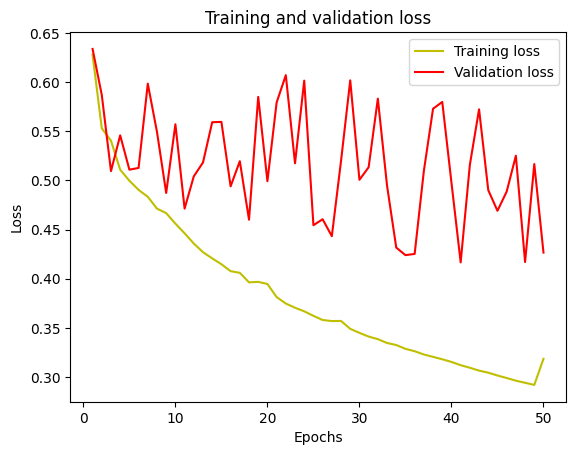

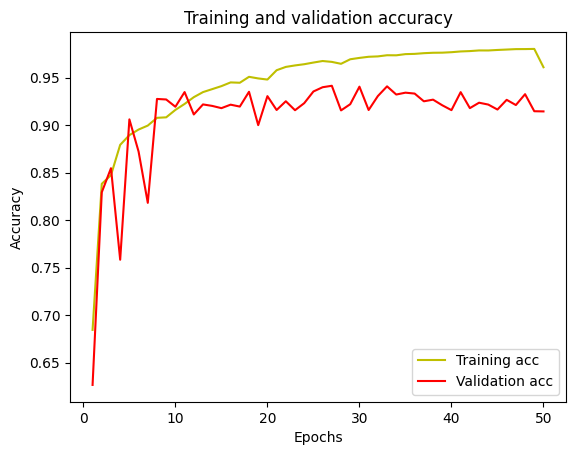

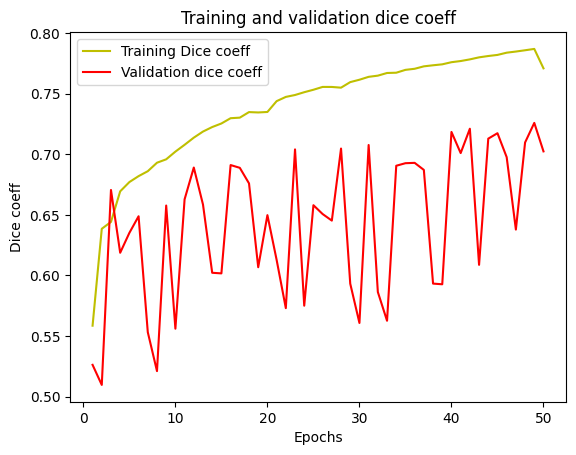

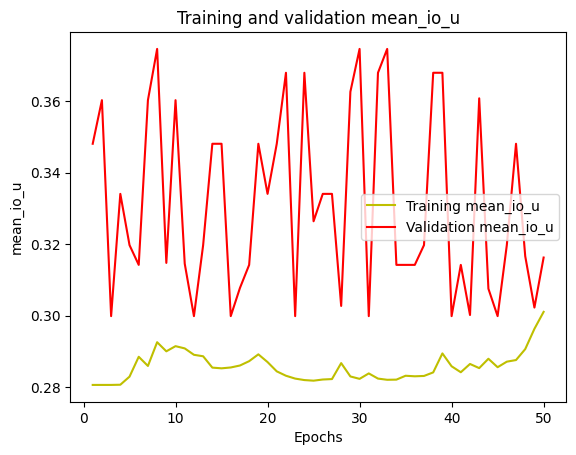

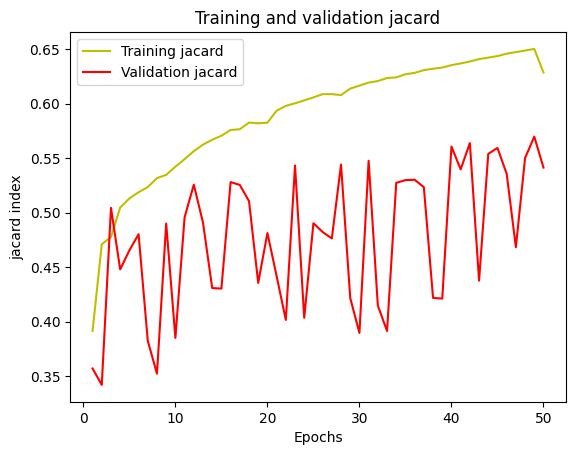

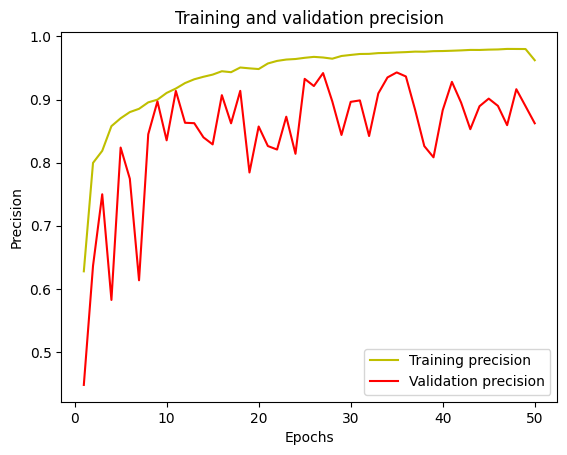

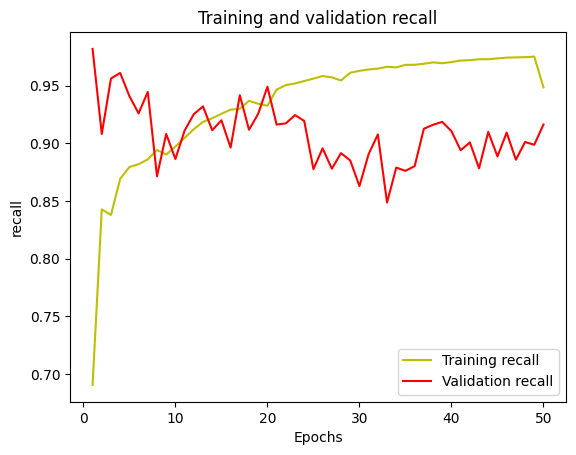

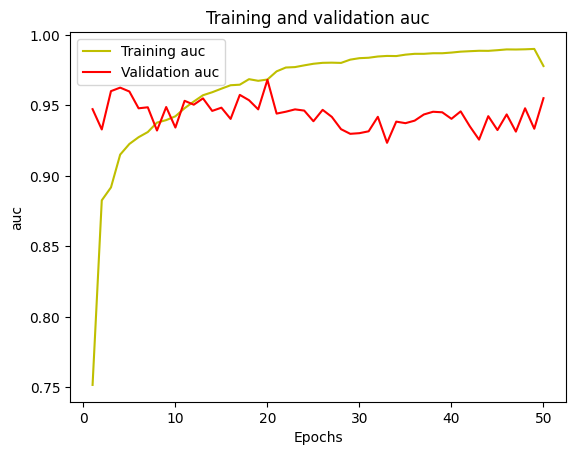

In [ ]:
##Results with 50 epochs
#plot the training and validation accuracy and loss at each epoch
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

acc = model_history.history['dice_coef']
val_acc = model_history.history['val_dice_coef']
plt.plot(epochs, acc, 'y', label='Training Dice coeff')
plt.plot(epochs, val_acc, 'r', label='Validation dice coeff')
plt.title('Training and validation dice coeff')
plt.xlabel('Epochs')
plt.ylabel('Dice coeff')
plt.legend()
plt.show()

acc = model_history.history['mean_io_u']
val_acc = model_history.history['val_mean_io_u']
plt.plot(epochs, acc, 'y', label='Training mean_io_u')
plt.plot(epochs, val_acc, 'r', label='Validation mean_io_u')
plt.title('Training and validation mean_io_u')
plt.xlabel('Epochs')
plt.ylabel('mean_io_u')
plt.legend()
plt.show()

acc = model_history.history['jacard']
val_acc = model_history.history['val_jacard']
plt.plot(epochs, acc, 'y', label='Training jacard')
plt.plot(epochs, val_acc, 'r', label='Validation jacard')
plt.title('Training and validation jacard')
plt.xlabel('Epochs')
plt.ylabel('jacard index')
plt.legend()
plt.show()

acc = model_history.history['precision']
val_acc = model_history.history['val_precision']
plt.plot(epochs, acc, 'y', label='Training precision')
plt.plot(epochs, val_acc, 'r', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

acc = model_history.history['recall']
val_acc = model_history.history['val_recall']
plt.plot(epochs, acc, 'y', label='Training recall')
plt.plot(epochs, val_acc, 'r', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()
plt.show()


acc = model_history.history['auc']
val_acc = model_history.history['val_auc']
plt.plot(epochs, acc, 'y', label='Training auc')
plt.plot(epochs, val_acc, 'r', label='Validation auc')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/project/calcium_data/U-net/models/hellacells_unet_50epochs.hdf5')

In [ ]:
model_checkpoint = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=200,
    verbose=0)
  #(monitor='loss',verbose=0, save_best_only=True)

model_history = model.fit(train_generator, steps_per_epoch=num_train//train_batch, epochs=50, callbacks=[model_checkpoint],
                                      validation_data=test_generator, validation_steps=num_test//test_batch)


Found 318 images belonging to 1 classes.
Found 318 images belonging to 1 classes.
Epoch 1/50
106/106 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.5612 - dice_coef: 0.4631 - jacard: 0.3030 - auc: 0.5420 - mean_io_u: 0.2806 - precision: 0.0000e+00 - recall: 0.0000e+00Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
106/106 [==============================] - 134s 967ms/step - loss: 0.7331 - accuracy: 0.5612 - dice_coef: 0.4631 - jacard: 0.3030 - auc: 0.5420 - mean_io_u: 0.2806 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6645 - val_accuracy: 0.6961 - val_dice_coef: 0.3871 - val_jacard: 0.2400 - val_auc: 0.5296 - val_mean_io_u: 0.3481 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
106/106 [==============================] - 103s 974ms/step - loss: 0.7618 - accuracy: 0.5612 - dice_coef: 0.4738 - jacard: 0.3116 - auc: 0.5507 - mean_io_u: 0.2806 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6779

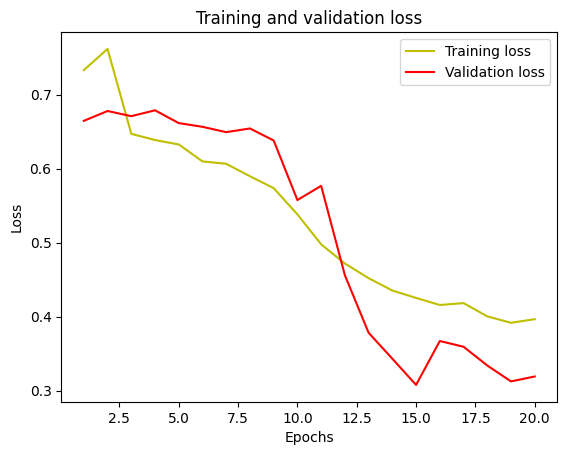

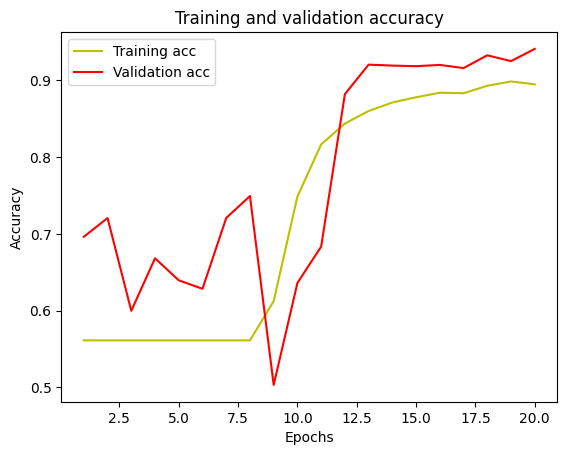

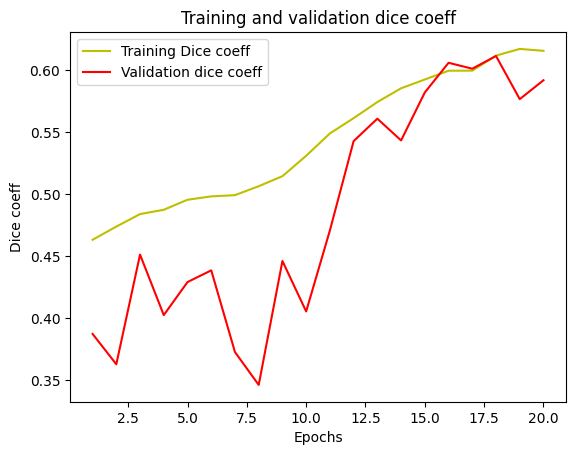

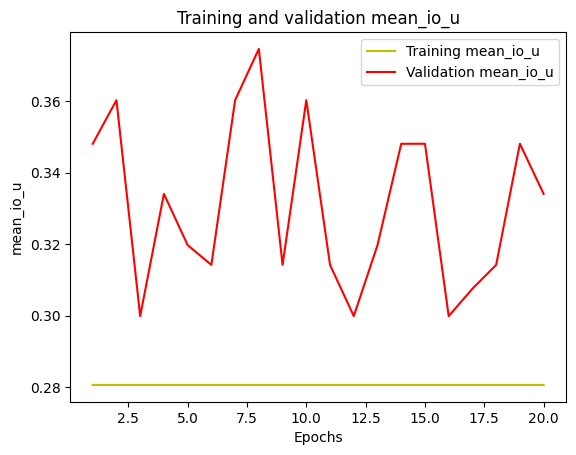

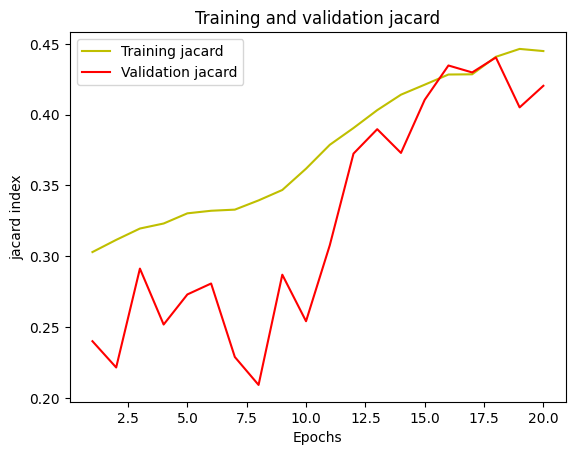

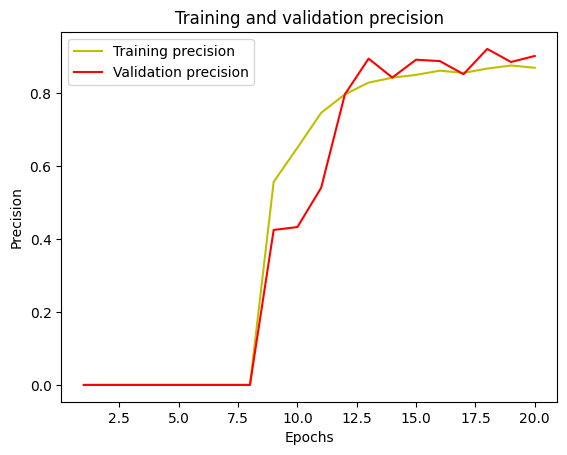

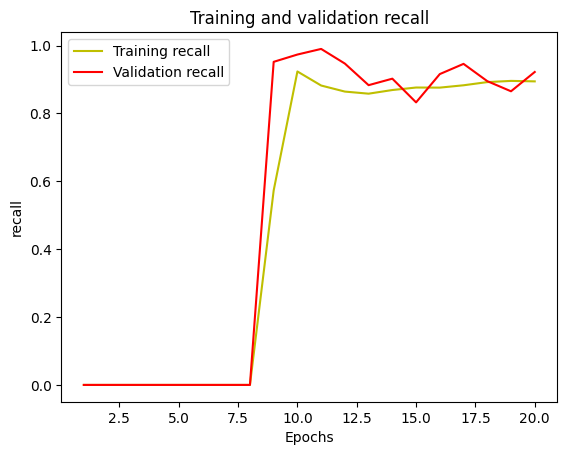

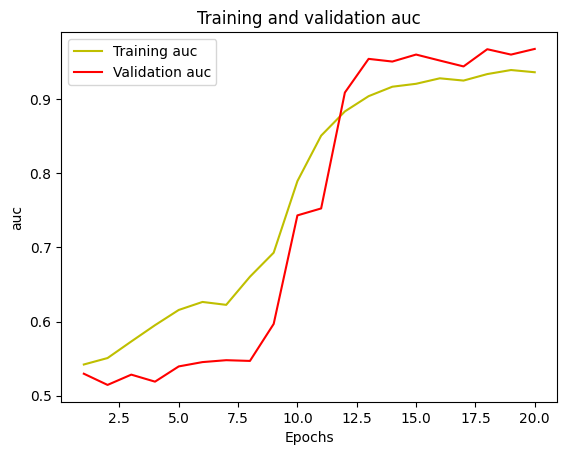

In [ ]:
##Results with 20 epochs
#plot the training and validation accuracy and loss at each epoch
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

acc = model_history.history['dice_coef']
val_acc = model_history.history['val_dice_coef']
plt.plot(epochs, acc, 'y', label='Training Dice coeff')
plt.plot(epochs, val_acc, 'r', label='Validation dice coeff')
plt.title('Training and validation dice coeff')
plt.xlabel('Epochs')
plt.ylabel('Dice coeff')
plt.legend()
plt.show()

acc = model_history.history['mean_io_u']
val_acc = model_history.history['val_mean_io_u']
plt.plot(epochs, acc, 'y', label='Training mean_io_u')
plt.plot(epochs, val_acc, 'r', label='Validation mean_io_u')
plt.title('Training and validation mean_io_u')
plt.xlabel('Epochs')
plt.ylabel('mean_io_u')
plt.legend()
plt.show()

acc = model_history.history['jacard']
val_acc = model_history.history['val_jacard']
plt.plot(epochs, acc, 'y', label='Training jacard')
plt.plot(epochs, val_acc, 'r', label='Validation jacard')
plt.title('Training and validation jacard')
plt.xlabel('Epochs')
plt.ylabel('jacard index')
plt.legend()
plt.show()

acc = model_history.history['precision']
val_acc = model_history.history['val_precision']
plt.plot(epochs, acc, 'y', label='Training precision')
plt.plot(epochs, val_acc, 'r', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

acc = model_history.history['recall']
val_acc = model_history.history['val_recall']
plt.plot(epochs, acc, 'y', label='Training recall')
plt.plot(epochs, val_acc, 'r', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()
plt.show()


acc = model_history.history['auc']
val_acc = model_history.history['val_auc']
plt.plot(epochs, acc, 'y', label='Training auc')
plt.plot(epochs, val_acc, 'r', label='Validation auc')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()
plt.show()

In [ ]:
model_checkpoint = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)
  #(monitor='loss',verbose=0, save_best_only=True)

model_history = model.fit(train_generator, steps_per_epoch=num_train//train_batch, epochs=50, callbacks=[model_checkpoint],
                                      validation_data=test_generator, validation_steps=num_test//test_batch)


Found 318 images belonging to 1 classes.
Found 318 images belonging to 1 classes.
Epoch 1/50
106/106 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.8204 - dice_coef: 0.6913 - jacard: 0.5348 - auc_34: 0.8881 - mean_io_u_34: 0.2806 - precision_34: 0.7751 - recall_34: 0.8321Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
106/106 [==============================] - 120s 913ms/step - loss: 0.4532 - accuracy: 0.8204 - dice_coef: 0.6913 - jacard: 0.5348 - auc_34: 0.8881 - mean_io_u_34: 0.2806 - precision_34: 0.7751 - recall_34: 0.8321 - val_loss: 0.2516 - val_accuracy: 0.9220 - val_dice_coef: 0.7136 - val_jacard: 0.5547 - val_auc_34: 0.9627 - val_mean_io_u_34: 0.3481 - val_precision_34: 0.8852 - val_recall_34: 0.8539
Epoch 2/50
106/106 [==============================] - 96s 904ms/step - loss: 0.2520 - accuracy: 0.8950 - dice_coef: 0.8224 - jacard: 0.6997 - auc_34: 0.9609 - mean_io_u_34: 0.2814 - precision_34: 0.8807 - recall_34: 0.8798 - v

In [ ]:
model.save('/content/drive/MyDrive/project/calcium_data/U-net/models/hellacells_unet.hdf5')

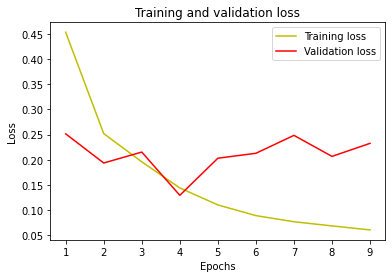

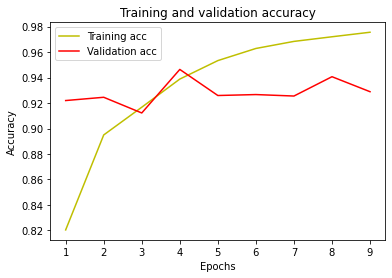

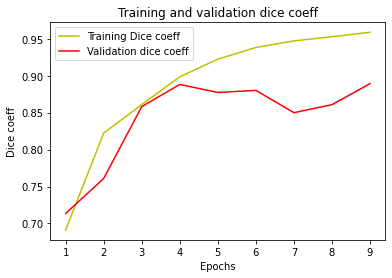

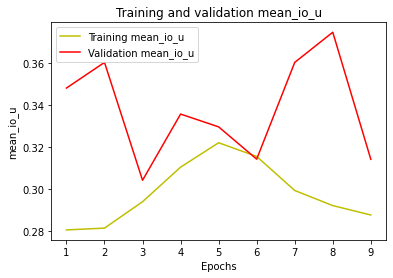

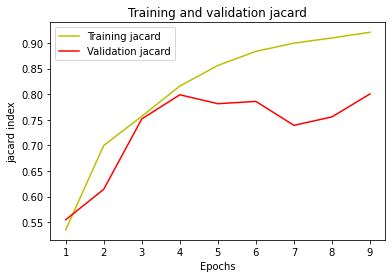

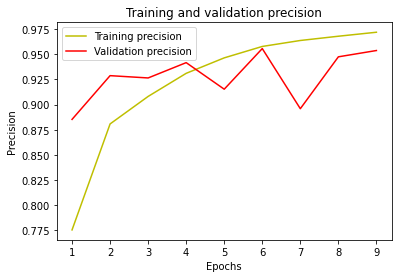

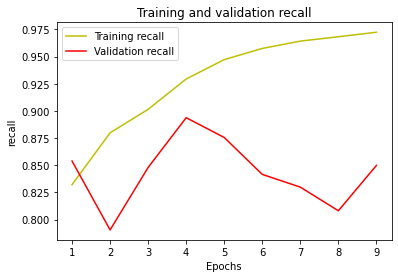

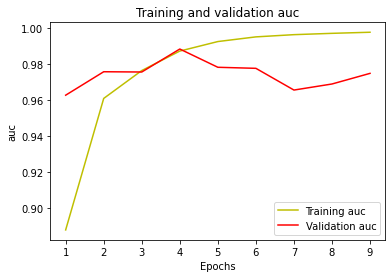

In [ ]:
##Results with 20 epochs
#plot the training and validation accuracy and loss at each epoch
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

acc = model_history.history['dice_coef']
val_acc = model_history.history['val_dice_coef']
plt.plot(epochs, acc, 'y', label='Training Dice coeff')
plt.plot(epochs, val_acc, 'r', label='Validation dice coeff')
plt.title('Training and validation dice coeff')
plt.xlabel('Epochs')
plt.ylabel('Dice coeff')
plt.legend()
plt.show()

acc = model_history.history['mean_io_u_34']
val_acc = model_history.history['val_mean_io_u_34']
plt.plot(epochs, acc, 'y', label='Training mean_io_u')
plt.plot(epochs, val_acc, 'r', label='Validation mean_io_u')
plt.title('Training and validation mean_io_u')
plt.xlabel('Epochs')
plt.ylabel('mean_io_u')
plt.legend()
plt.show()

acc = model_history.history['jacard']
val_acc = model_history.history['val_jacard']
plt.plot(epochs, acc, 'y', label='Training jacard')
plt.plot(epochs, val_acc, 'r', label='Validation jacard')
plt.title('Training and validation jacard')
plt.xlabel('Epochs')
plt.ylabel('jacard index')
plt.legend()
plt.show()

acc = model_history.history['precision_34']
val_acc = model_history.history['val_precision_34']
plt.plot(epochs, acc, 'y', label='Training precision')
plt.plot(epochs, val_acc, 'r', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

acc = model_history.history['recall_34']
val_acc = model_history.history['val_recall_34']
plt.plot(epochs, acc, 'y', label='Training recall')
plt.plot(epochs, val_acc, 'r', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()
plt.show()


acc = model_history.history['auc_34']
val_acc = model_history.history['val_auc_34']
plt.plot(epochs, acc, 'y', label='Training auc')
plt.plot(epochs, val_acc, 'r', label='Validation auc')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()
plt.show()

In [ ]:
model_checkpoint = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=0)
  #(monitor='loss',verbose=0, save_best_only=True)

model_history = model.fit(train_generator, steps_per_epoch=num_train//train_batch, epochs=30, callbacks=[model_checkpoint],
                                      validation_data=test_generator, validation_steps=num_test//test_batch)


Found 318 images belonging to 1 classes.
Found 318 images belonging to 1 classes.
Epoch 1/30
106/106 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9807 - dice_coef: 0.9674 - jacard: 0.9370 - auc_34: 0.9983 - mean_io_u_34: 0.2828 - precision_34: 0.9775 - recall_34: 0.9785Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
106/106 [==============================] - 100s 931ms/step - loss: 0.0491 - accuracy: 0.9807 - dice_coef: 0.9674 - jacard: 0.9370 - auc_34: 0.9983 - mean_io_u_34: 0.2828 - precision_34: 0.9775 - recall_34: 0.9785 - val_loss: 0.2817 - val_accuracy: 0.9220 - val_dice_coef: 0.8623 - val_jacard: 0.7580 - val_auc_34: 0.9645 - val_mean_io_u_34: 0.3481 - val_precision_34: 0.8748 - val_recall_34: 0.8675
Epoch 2/30
106/106 [==============================] - 98s 925ms/step - loss: 0.0469 - accuracy: 0.9815 - dice_coef: 0.9686 - jacard: 0.9392 - auc_34: 0.9984 - mean_io_u_34: 0.2822 - precision_34: 0.9786 - recall_34: 0.9792 - v

## Results on Train

In [ ]:
image_names = glob.glob("/content/drive/MyDrive/project/calcium_data/test/images/*.png")
image_names.sort()
image_names_subset = image_names #[0:num_images]
images = [cv2.imread(img, 0) for img in image_names_subset]
print(image_names)

['/content/drive/MyDrive/project/calcium_data/test/images/s12.png', '/content/drive/MyDrive/project/calcium_data/test/images/s23.png', '/content/drive/MyDrive/project/calcium_data/test/images/s24.png', '/content/drive/MyDrive/project/calcium_data/test/images/s26.png', '/content/drive/MyDrive/project/calcium_data/test/images/s27.png']


In [ ]:
img = [cv2.resize(ing, (80,80)) for ing in images]

In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/project/calcium_data/test/labels/*.png")
mask_names.sort()
mask_names_subset = mask_names #[0:num_images]
masks = [cv2.imread(mask, cv2.IMREAD_GRAYSCALE) for mask in mask_names_subset]

In [ ]:
mas = [cv2.resize(ing, (80,80)) for ing in masks]

In [ ]:
mask_dataset = np.array(mas)
mask_dataset = np.expand_dims(mask_dataset, axis = -1)

In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


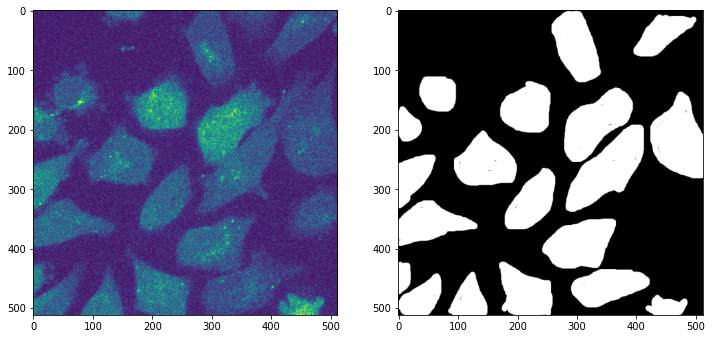

In [ ]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number,:,:,0])
plt.subplot(122)
plt.imshow(mask_dataset[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
from keras.models import load_model
# model = load_model("/content/drive/MyDrive/dendrites_cal/U_net/models/my_model11.hdf5", compile=False)
model = load_model('/content/drive/MyDrive/project/calcium_data/U-net/models/model_110_epoch_calcium_tf.hdf5', compile = False)

In [ ]:
#IOU
y_pred=model.predict(image_dataset)
y_pred_thresholded = y_pred > 0.5

1/1 [==============================] - 9s 9s/step


In [ ]:
# Train
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, mask_dataset)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9295526


In [ ]:
# Test
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, mask_dataset)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.83908045


In [ ]:
image_names = glob.glob("/content/drive/MyDrive/project/conference/images_after_CLAHE/*.png")
print(image_names)

['/content/drive/MyDrive/project/conference/images_after_CLAHE/image_0.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_1.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_5.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_2.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_3.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_7.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_6.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_4.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_8.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_10.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_12.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_13.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_9.png', '/conten

In [ ]:
image_names.sort()
print(image_names)

['/content/drive/MyDrive/project/conference/images_after_CLAHE/image_0.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_1.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_10.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_11.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_12.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_13.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_14.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_15.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_16.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_17.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_18.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_19.png', '/content/drive/MyDrive/project/conference/images_after_CLAHE/image_2.png', '

In [ ]:
image_names_subset = image_names #[0:num_images]

In [ ]:
images = [cv2.imread(img, 0) for img in image_names_subset]

In [ ]:
img = [cv2.resize(ing, (80,80)) for ing in images]

In [ ]:
image_dataset = np.array(img)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/project/conference/masks_after_CLAHE/*.png")
mask_names.sort()
mask_names_subset = mask_names #[0:num_images]
masks = [cv2.imread(mask, cv2.IMREAD_GRAYSCALE) for mask in mask_names_subset]

In [ ]:
mas = [cv2.resize(ing, (80,80)) for ing in masks]

In [ ]:
mask_dataset = np.array(mas)
mask_dataset = np.expand_dims(mask_dataset, axis = -1)

In [ ]:
np.unique(mask_dataset)

array([  0, 255], dtype=uint8)

In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


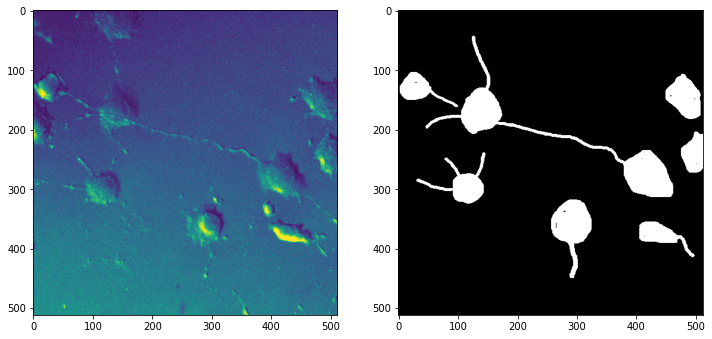

In [ ]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/dendrites_cal/U_net/models/my_model_29.hdf5", compile=False)
# model = load_model('/content/drive/MyDrive/project/conference/Retinal-Vessel-Segmentation-main/U-net/models/my_model_12.hdf5', compile = False)

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

1/1 [==============================] - 112s 112s/step


In [ ]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7814952


In [ ]:
SAVE_NAME = 'my_model'
initial_model_name = None

train_eval_drive(save_name=SAVE_NAME, initial_model_name = initial_model_name, n_samples= train_sample_number, epochs=30)

Padding is done.


<ipython-input-9-6203a9b2f27d>:6: UserWarning: /content/drive/MyDrive/project/dendrites/tmp_train/labels/deneme_19.png is a low contrast image
  io.imsave(output_folder + '/' + file, tmp)


Padding is done.
Padding is done.
Padding is done.


<ipython-input-20-58defd2f24f1>:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator, steps_per_epoch=n_samples//train_batch, epochs=1, callbacks=[model_checkpoint],


Found 465 images belonging to 1 classes.
Found 465 images belonging to 1 classes.
155/155 [==============================] - ETA: 0s - loss: 0.4649 - accuracy: 0.8437 - dice_coef: 0.2056 - jacard: 0.1163 - auc_2: 0.6014 - mean_io_u_2: 0.4220 - precision_2: 0.2766 - recall_2: 0.0012Found 27 images belonging to 1 classes.
Found 27 images belonging to 1 classes.

Epoch 1: loss improved from inf to 0.46487, saving model to /content/drive/MyDrive/project/dendrites/models/my_model_0.hdf5
155/155 [==============================] - ETA: 0s - loss: 0.3528 - accuracy: 0.8444 - dice_coef: 0.3096 - jacard: 0.1847 - auc_3: 0.8028 - mean_io_u_3: 0.4222 - precision_3: 0.2701 - recall_3: 3.0054e-06
Epoch 1: loss improved from inf to 0.35277, saving model to /content/drive/MyDrive/project/dendrites/models/my_model_1.hdf5
155/155 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8432 - dice_coef: 0.3581 - jacard: 0.2192 - auc_4: 0.8605 - mean_io_u_4: 0.4216 - precision_4: 0.5000 - 

In [ ]:
SAVE_NAME = 'my_model'
initial_model_name = None

train_eval_drive(save_name=SAVE_NAME, initial_model_name = initial_model_name, n_samples= train_sample_number, epochs=100)

Padding is done.


<ipython-input-9-6203a9b2f27d>:6: UserWarning: /content/drive/MyDrive/project/dendrites/tmp_train/labels/deneme_19.png is a low contrast image
  io.imsave(output_folder + '/' + file, tmp)


Padding is done.
Padding is done.
Padding is done.


<ipython-input-20-58defd2f24f1>:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator, steps_per_epoch=n_samples//train_batch, epochs=1, callbacks=[model_checkpoint],


Found 465 images belonging to 1 classes.
Found 465 images belonging to 1 classes.
155/155 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.8440 - dice_coef: 0.2069 - jacard: 0.1169 - auc_35: 0.5928 - mean_io_u_35: 0.4220 - precision_35: 0.0000e+00 - recall_35: 0.0000e+00Found 27 images belonging to 1 classes.
Found 27 images belonging to 1 classes.

Epoch 1: loss improved from inf to 0.45842, saving model to /content/drive/MyDrive/project/dendrites/models/my_model_0.hdf5
155/155 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.8444 - dice_coef: 0.3015 - jacard: 0.1794 - auc_36: 0.7912 - mean_io_u_36: 0.4222 - precision_36: 0.0000e+00 - recall_36: 0.0000e+00
Epoch 1: loss improved from inf to 0.36135, saving model to /content/drive/MyDrive/project/dendrites/models/my_model_1.hdf5
155/155 [==============================] - ETA: 0s - loss: 0.3242 - accuracy: 0.8432 - dice_coef: 0.3483 - jacard: 0.2121 - auc_37: 0.8479 - mean_io_u_37: 0.4216 - 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, Conv3DTranspose, Concatenate, MaxPooling3D, UpSampling3D, BatchNormalization, Activation
from tensorflow.keras.models import Model

def dense_block(input_tensor, filters):
    x1 = Conv3D(filters, kernel_size=(3, 3, 3), padding='same')(input_tensor)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x2 = Concatenate()([input_tensor, x1])
    x2 = Conv3D(filters, kernel_size=(3, 3, 3), padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x3 = Concatenate()([input_tensor, x1, x2])
    x3 = Conv3D(filters, kernel_size=(3, 3, 3), padding='same')(x3)
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)
    output_tensor = Concatenate()([input_tensor, x1, x2, x3])
    return output_tensor

def dense_vnet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # Encoding path
    conv1 = Conv3D(16, kernel_size=(3, 3, 3), padding='same')(x)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    dense_block1 = dense_block(conv1, 16)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(dense_block1)

    conv2 = Conv3D(32, kernel_size=(3, 3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    dense_block2 = dense_block(conv2, 32)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(dense_block2)

    conv3 = Conv3D(64, kernel_size=(3, 3, 3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    dense_block3 = dense_block(conv3, 64)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(dense_block3)

    # Decoding path
    up4 = Conv3DTranspose(64, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(pool3)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    concat4 = Concatenate()([up4, dense_block3])
    conv4 = Conv3D(64, kernel_size=(3, 3, 3), padding='same')(concat4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    dense_block4 = dense_block(conv4, 64)

    up5 = Conv3DTranspose(32, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(dense_block4)
    up5 = BatchNormalization()(up5)
    up5 = Activation('relu')(up5)
    concat5 = Concatenate()([up5, dense_block2])
    conv5 = Conv3D(32, kernel_size=(3, 3, 3), padding='same')(concat5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    dense_block5 = dense_block(conv5, 32)

    up6 = Conv3DTranspose(16, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(dense_block5)
    up6 = BatchNormalization()(up6)
    up6 = Activation('relu')(up6)
    concat6 = Concatenate()([up6, dense_block1])
    conv6 = Conv3D(16, kernel_size=(3, 3, 3), padding='same')(concat6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    dense_block6 = dense_block(conv6, 16)

    # Output layer
    outputs = Conv3D(num_classes, kernel_size=(1, 1, 1), activation='softmax')(dense_block6)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model